In [2]:
import os
os.chdir(os.path.dirname(os.getcwd()))

In [10]:
import pandas as pd
from utils.lgb_feature_engineering_train import init_train_data
import matplotlib.pyplot as plt


In [3]:
# list paths in 'data/citylearn_challenge_2022_phase_1/' that start with Build
# and end with .csv
files = [f for f in os.listdir('data/citylearn_challenge_2022_phase_1/') if f.startswith('Build') and f.endswith('.csv')]
files

['Building_4.csv',
 'Building_5.csv',
 'Building_1.csv',
 'Building_2.csv',
 'Building_3.csv']

In [4]:
weather = pd.read_csv('data/citylearn_challenge_2022_phase_1/weather.csv')
weather

,Outdoor Drybulb Temperature [C],Relative Humidity [%],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],6h Prediction Outdoor Drybulb Temperature [C],12h Prediction Outdoor Drybulb Temperature [C],24h Prediction Outdoor Drybulb Temperature [C],6h Prediction Relative Humidity [%],12h Prediction Relative Humidity [%],24h Prediction Relative Humidity [%],6h Prediction Diffuse Solar Radiation [W/m2],12h Prediction Diffuse Solar Radiation [W/m2],24h Prediction Diffuse Solar Radiation [W/m2],6h Prediction Direct Solar Radiation [W/m2],12h Prediction Direct Solar Radiation [W/m2],24h Prediction Direct Solar Radiation [W/m2]
0,20.0,84.0,0.0,0.0,18.3,22.8,20.0,81.0,68.0,81.0,25.0,964.0,0.0,100.0,815.0,0.0
1,20.1,79.0,0.0,0.0,19.4,22.8,19.4,79.0,71.0,87.0,201.0,966.0,0.0,444.0,747.0,0.0
2,19.7,78.0,0.0,0.0,21.1,22.2,19.4,73.0,73.0,87.0,420.0,683.0,0.0,592.0,291.0,0.0
3,19.3,78.0,0.0,0.0,22.2,22.8,19.4,71.0,71.0,90.0,554.0,522.0,0.0,491.0,153.0,0.0
4,18.9,78.0,0.0,0.0,21.7,22.2,18.9,73.0,71.0,90.0,778.0,444.0,0.0,734.0,174.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,20.6,84.0,26.0,130.0,20.1,19.4,20.6,79.0,79.0,73.0,0.0,201.0,27.0,0.0,444.0,143.0
8756,21.1,81.0,0.0,0.0,19.7,21.1,20.0,78.0,73.0,76.0,0.0,420.0,0.0,0.0,592.0,0.0
8757,21.7,79.0,0.0,0.0,19.3,22.2,20.6,78.0,71.0,70.0,0.0,554.0,0.0,0.0,491.0,0.0
8758,21.3,76.0,0.0,0.0,18.9,21.7,20.6,78.0,73.0,73.0,0.0,778.0,0.0,0.0,734.0,0.0


In [7]:
scens_point = pd.read_csv('debug_logs/scenarios_point_recurrent_9000_1.csv')
# rename columns from +1 to +24 to +0 to +23
scens_point.columns = [f'{int(c.split("+")[1].split("h")[0])-1}' if c.startswith('+') else c for c in scens_point.columns]
# add plus sign to column names
scens_point.columns = [f'forecast+{c}' if c.isdigit() else c for c in scens_point.columns]
# drop scenario column
scens_point = scens_point.drop(columns=['scenario'])
# save to csv
scens_point.to_csv('point_forecast.csv', index=True)
scens_point

FileNotFoundError: [Errno 2] No such file or directory: 'debug_logs/scenarios_point_recurrent_9000_1.csv'

In [8]:
pv_capacity = [4.0, 4.0, 4.0, 5.0, 4.0]
# loop through csv files and extract consumption and generation data
all_buildings = pd.DataFrame()
for file in files:
    df = pd.read_csv('data/citylearn_challenge_2022_phase_1/' + file)
    filename = file.split('.')[0].split('_')[1]
    df = pd.concat([df, weather], axis=1)
    df['time_step'] = df.index
    df['building'] = int(filename) - 1
    df['PV capacity [kW]'] = pv_capacity[int(filename[-1])-1]
    df.drop(['Daylight Savings Status','DHW Heating [kWh]',
       'Cooling Load [kWh]', 'Heating Load [kWh]'], axis=1, inplace=True)
    # Remove column names containing the word 'Prediction'
    df = df[[col for col in df.columns if 'Prediction' not in col]]
    all_buildings = pd.concat([all_buildings, df], axis=0)
all_buildings.rename(columns={'Hour': 'hour', 'Month': 'month', 'Day Type': 'day_type'}, inplace=True)
#move time_step and building to front
cols = all_buildings.columns.tolist()
cols = cols[-2:] + cols[:-2]
all_buildings = all_buildings[cols]
# remove columns with no data
all_buildings = all_buildings.dropna(axis=1, how='all')
all_buildings


,building,PV capacity [kW],month,hour,day_type,Equipment Electric Power [kWh],Solar Generation [W/kW],Outdoor Drybulb Temperature [C],Relative Humidity [%],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],time_step
0,3,5.0,7.0,24.0,7.0,2.819150,0.000000,20.0,84.0,0.0,0.0,0
1,3,5.0,8.0,1.0,1.0,1.928167,0.000000,20.1,79.0,0.0,0.0,1
2,3,5.0,8.0,2.0,1.0,0.475817,0.000000,19.7,78.0,0.0,0.0,2
3,3,5.0,8.0,3.0,1.0,0.458233,0.000000,19.3,78.0,0.0,0.0,3
4,3,5.0,8.0,4.0,1.0,0.446017,0.000000,18.9,78.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2,4.0,7.0,19.0,1.0,1.472417,13.670833,20.6,84.0,26.0,130.0,8755
8756,2,4.0,7.0,20.0,1.0,1.075767,0.000000,21.1,81.0,0.0,0.0,8756
8757,2,4.0,7.0,21.0,1.0,1.162883,0.000000,21.7,79.0,0.0,0.0,8757
8758,2,4.0,7.0,22.0,1.0,1.107300,0.000000,21.3,76.0,0.0,0.0,8758


In [39]:
# save to csv
all_buildings.to_csv('all_buildings_phase1.csv', index=True)

In [7]:
path_to_bu1 = "data/citylearn_challenge_2022_phase_3/Building_11.csv"
path_to_bu2 = "data/citylearn_challenge_2022_phase_3/Building_12.csv"
path_to_bu3 = "data/citylearn_challenge_2022_phase_3/Building_13.csv"
path_to_bu4 = "data/citylearn_challenge_2022_phase_3/Building_14.csv"
path_to_bu5 = "data/citylearn_challenge_2022_phase_3/Building_15.csv"
path_to_bu6 = "data/citylearn_challenge_2022_phase_3/Building_16.csv"
path_to_bu7 = "data/citylearn_challenge_2022_phase_3/Building_17.csv"

path_to_bu = [path_to_bu1, path_to_bu2, path_to_bu3, path_to_bu4, path_to_bu5, path_to_bu6, path_to_bu7]

x_train, y_train = pd.DataFrame(), pd.DataFrame()
for i in range(5):
        x, y = init_train_data(path_to_bu[i], 'solar')
        x['building_id'] = i
        x_train = x_train.append(x)
        y_train = y_train.append(y)
targets = [item for item in y_train.columns if 'Net_Future_' in item]

Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish


In [8]:
y_train

,Solar_Future_0,Solar_Future_1,Solar_Future_2,Solar_Future_3,Solar_Future_4,Solar_Future_5,Solar_Future_6,Solar_Future_7,Solar_Future_8,Solar_Future_9,...,Solar_Future_14,Solar_Future_15,Solar_Future_16,Solar_Future_17,Solar_Future_18,Solar_Future_19,Solar_Future_20,Solar_Future_21,Solar_Future_22,Solar_Future_23
30,8.484375,32.28125,98.0,224.5,364.0,490.0,583.00000,629.00000,634.50000,597.500000,...,0.0000,0.0000,0.0000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
31,32.281250,98.00000,224.5,364.0,490.0,583.0,629.00000,634.50000,597.50000,514.500000,...,0.0000,0.0000,0.0000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,10.679688
32,98.000000,224.50000,364.0,490.0,583.0,629.0,634.50000,597.50000,514.50000,386.000000,...,0.0000,0.0000,0.0000,0.00000,0.00000,0.00000,0.000000,0.000000,10.679688,36.281250
33,224.500000,364.00000,490.0,583.0,629.0,634.5,597.50000,514.50000,386.00000,212.375000,...,0.0000,0.0000,0.0000,0.00000,0.00000,0.00000,0.000000,10.679688,36.281250,103.062500
34,364.000000,490.00000,583.0,629.0,634.5,597.5,514.50000,386.00000,212.37500,25.203125,...,0.0000,0.0000,0.0000,0.00000,0.00000,0.00000,10.679688,36.281250,103.062500,219.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8732,0.000000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.000000,...,94.5000,123.1250,130.8750,80.18750,84.87500,112.93750,83.562500,26.406250,26.406250,60.593750
8733,0.000000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,60.593750,...,123.1250,130.8750,80.1875,84.87500,112.93750,83.56250,26.406250,26.406250,60.593750,0.000000
8734,0.000000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00000,60.59375,60.593750,...,130.8750,80.1875,84.8750,112.93750,83.56250,26.40625,26.406250,60.593750,0.000000,0.000000
8735,0.000000,0.00000,0.0,0.0,0.0,0.0,0.00000,60.59375,60.59375,60.593750,...,80.1875,84.8750,112.9375,83.56250,26.40625,26.40625,60.593750,0.000000,0.000000,0.000000


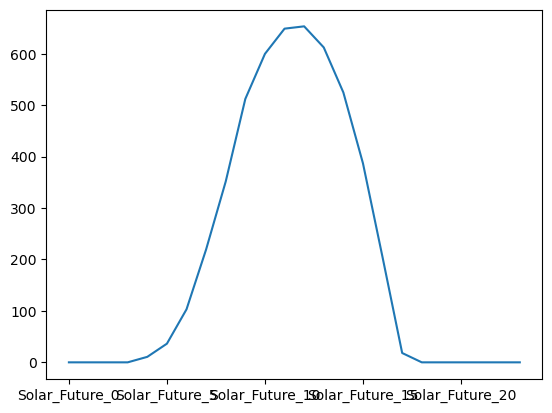

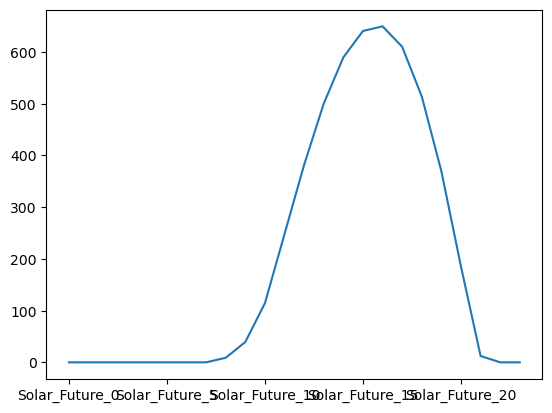

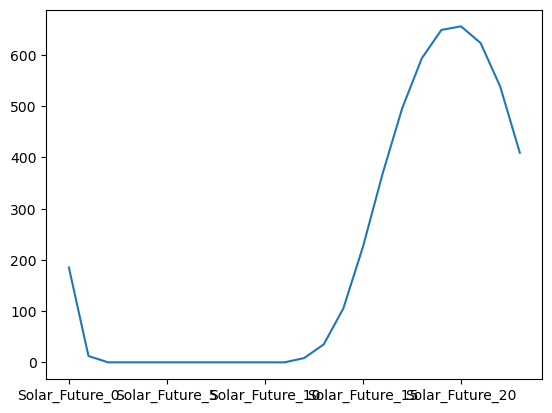

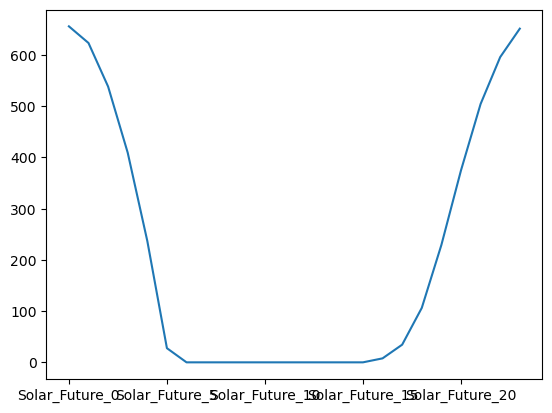

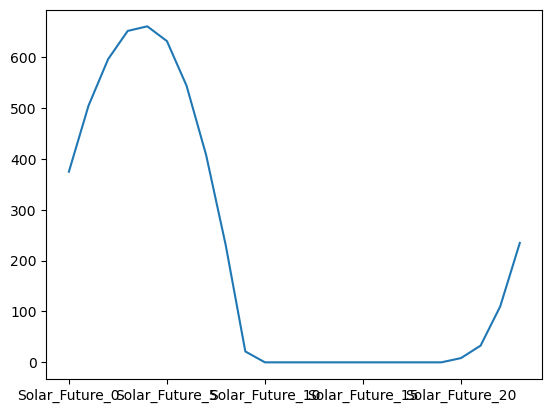

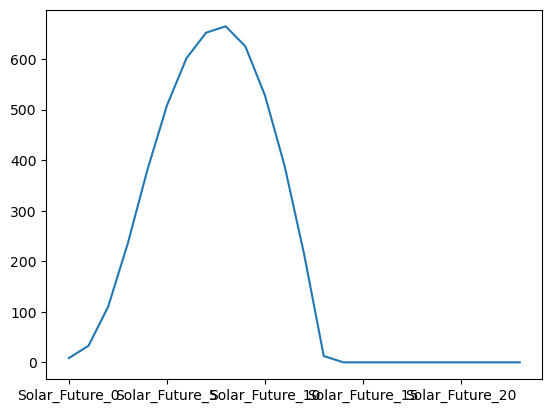

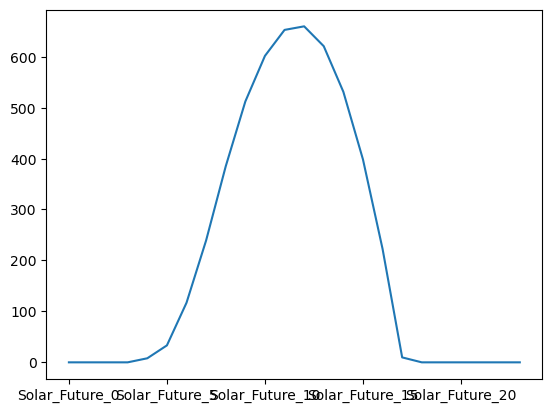

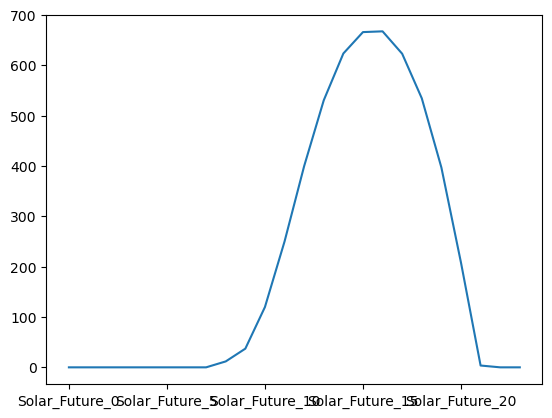

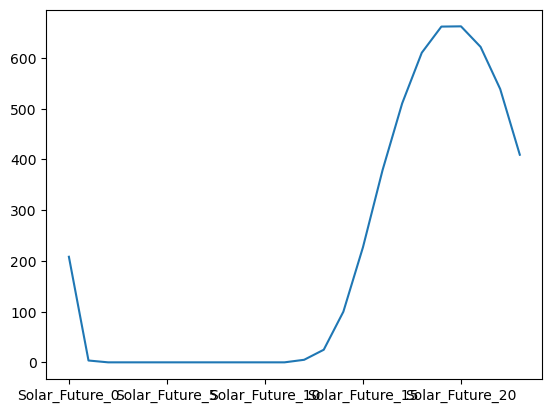

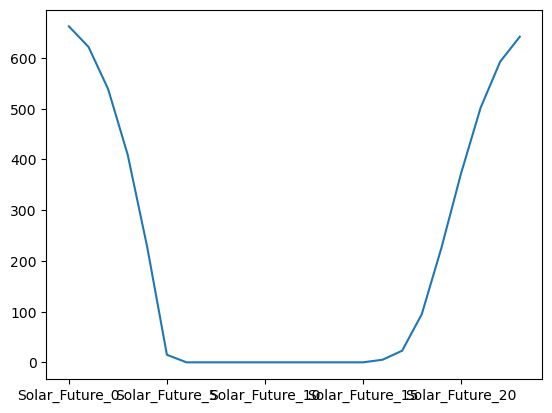

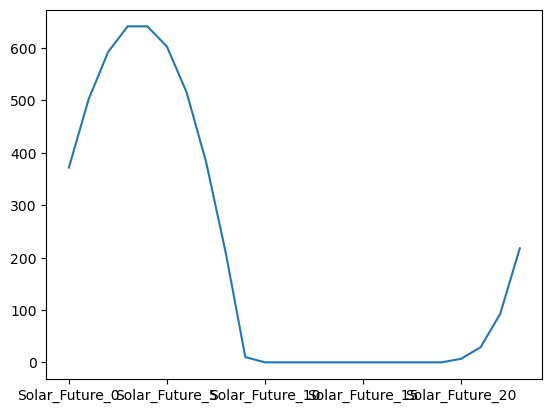

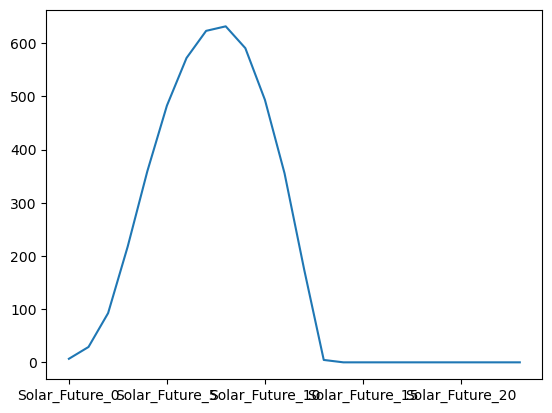

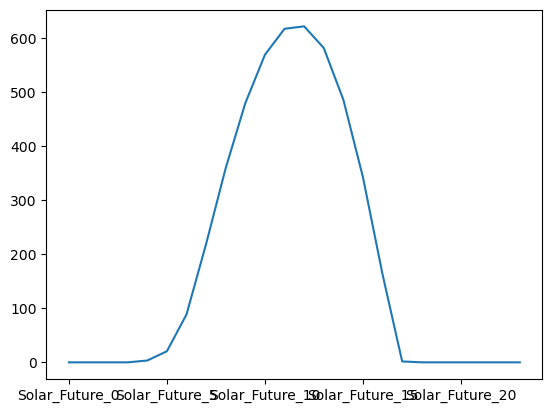

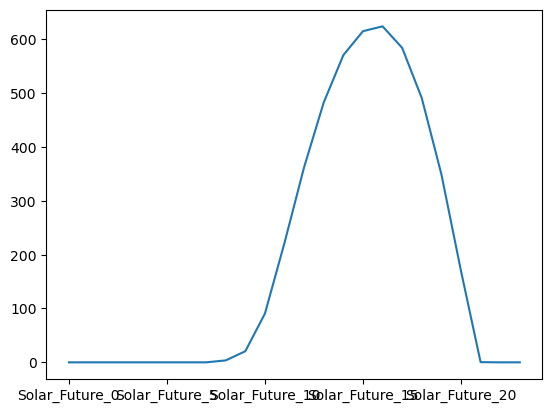

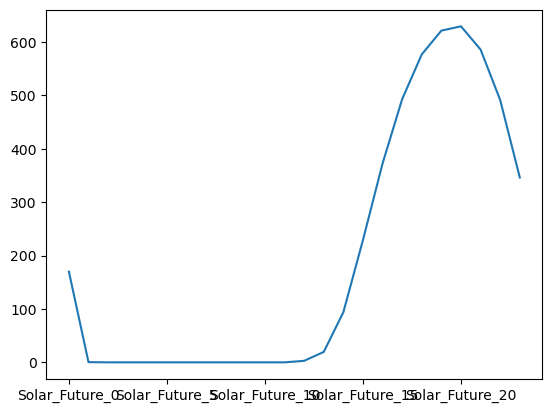

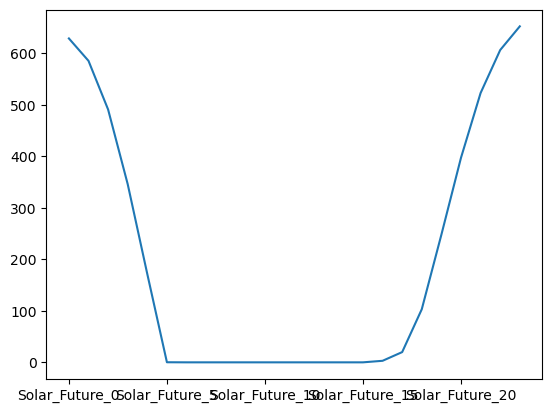

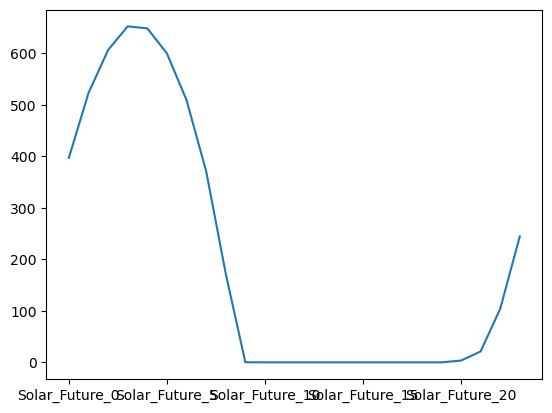

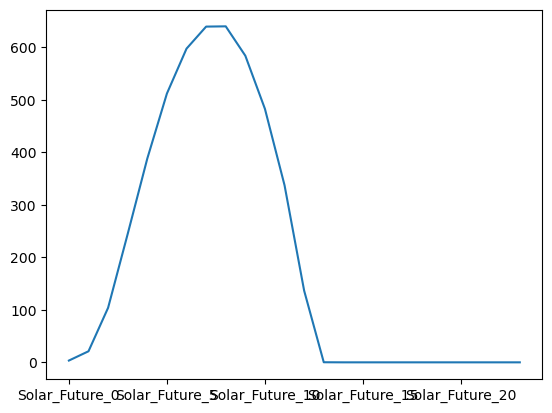

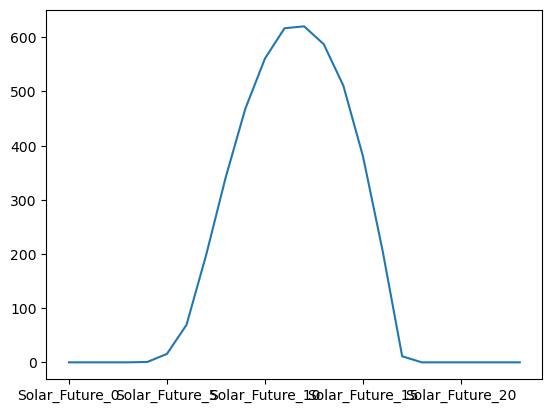

In [11]:
for i in range(20, 400, 20):
    y_train.iloc[i].plot()
    plt.show()